In [1]:
import sys
from pyspark import SparkContext
import matplotlib
import pandas as pd
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row

#sc = SparkContext()

In [2]:
rdd = sc.textFile("/Users/Furkankaya/IMDB_Analysis_Spark 2/rate_comment_data_top250a.txt")

# Here we fetch our data for training

In [3]:
interim1 = rdd.map(lambda line: (int(line.split("//*//")[0]), line.split("//*//")[1]))

interim2 = interim1.map(lambda t: Row(label=t[0], text=t[1]))

training1 = sqlContext.createDataFrame(interim2)
training1.show()



+-----+--------------------+
|label|                text|
+-----+--------------------+
|   10|Simply amazing. T...|
|    8|The best story ev...|
|   10|Busy dying or bus...|
|    8|Great story, wond...|
|    9|This Movie Saved ...|
|    8|Good , But It Is ...|
|   10|"The Godfather" i...|
|    9|Magnificent portr...|
|   10|An Epic, Masterfu...|
|    9|The Greatest Movi...|
|    8|A film of great p...|
|    9|One Can See Why I...|
|    8|Mario Puzo's soap...|
|   10|Breathtaking in i...|
|    7|Terrific continua...|
|    9|As good as the or...|
|    7|Sorry, but it jus...|
|   10|Overwritten Scrip...|
|   10|The Continuation ...|
|   10|The Batman of our...|
+-----+--------------------+
only showing top 20 rows



In [344]:
# collect the RDD to a list lambda 
from pyspark.sql import SQLContext

#interim = rdd.map(lambda line: (4.0 if int(line.split("//*//")[0]) >= 9.5 else (2.0 if 9 > int(line.split("//*//")[0]) >= 7 else (1.0 )), line.split("//*//")[1]))

interim = rdd.map(lambda line: (1 if int(line.split("//*//")[0]) >= 7 else (0), line.split("//*//")[1]))
interim = interim.map(lambda t: Row(label=t[0], text=t[1]))
sqlContext = SQLContext(sc)
training = sqlContext.createDataFrame(interim)


#our data for traning is mapped to binary values 1 for positive comment and 0 for negative.
#Then the values are turned into a dataframe

In [318]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, StopWordsRemover
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator



tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)


# Prepare test documents, which are unlabeled (id, text) tuples.

file_ = open("/Users/Furkankaya/IMDB_Analysis_Spark 2/rate_comment_data_test_data.txt", 'r')
a = file_.readline()

list=[]
for line in file_:
    review = line.split("||")[1]
    list.append(Row(text=(review)[0:len(review)-1]))
    

test = sqlContext.createDataFrame(list)
# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)

# The dataset prepared for testing is put into a dataframe and that dataframe is fed to the pipeline.

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()
    
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)


In [319]:
import time
start = time.time()
model = crossval.fit(training)
print("Took:", time.time()-start)

('Took:', 26.88003396987915)


In [320]:
prediction.select("text","prediction").show()


+--------------------+----------+
|                text|prediction|
+--------------------+----------+
|Animation I'd nev...|       1.0|
|StagedWhile many ...|       1.0|
|Work before pleas...|       1.0|
|13 seconds of wor...|       1.0|
|Pound that metalM...|       1.0|
|Decent sports act...|       1.0|
|This is the GWTW ...|       1.0|
|What you see is w...|       1.0|
|First Comic Sneez...|       0.0|
|What has Ott wrou...|       1.0|
|Great Drinking Mo...|       1.0|
|I hear the train ...|       1.0|
|Great Silent Shor...|       1.0|
|The train approac...|       1.0|
|But is it good?As...|       1.0|
|Soak a bloke; a h...|       1.0|
|The birth of the ...|       0.0|
|Animation here a ...|       1.0|
|Children dancing"...|       1.0|
|Simple premise, b...|       1.0|
+--------------------+----------+
only showing top 20 rows



In [321]:
#selected = prediction.select("text", "prediction")
#for row in selected.collect():
#   print(row)

In [333]:
myrawtest = sc.textFile("/Users/Furkankaya/IMDB_Analysis_Spark 2/rate_comment_data_test_data.txt")
#myrawtest.collect()
mappedtest = myrawtest.map(lambda line: (1 if int(line.split("||")[0]) >= 4 else (0), line.split("||")[1]))
mappedtests = mappedtest.map(lambda t: Row(label=t[0], text=t[1]))
testreduced = sqlContext.createDataFrame(mappedtests)
testreduced.show(10)
prediction.select("prediction","text").show(10)
#test.show()


+-----+--------------------+
|label|                text|
+-----+--------------------+
|    1|A Simple, Yet Imp...|
|    1|Animation I'd nev...|
|    1|StagedWhile many ...|
|    0|Work before pleas...|
|    1|13 seconds of wor...|
|    1|Pound that metalM...|
|    1|Decent sports act...|
|    1|This is the GWTW ...|
|    1|What you see is w...|
|    1|First Comic Sneez...|
+-----+--------------------+
only showing top 10 rows

+----------+--------------------+
|prediction|                text|
+----------+--------------------+
|       1.0|Animation I'd nev...|
|       1.0|StagedWhile many ...|
|       1.0|Work before pleas...|
|       1.0|13 seconds of wor...|
|       1.0|Pound that metalM...|
|       1.0|Decent sports act...|
|       1.0|This is the GWTW ...|
|       1.0|What you see is w...|
|       0.0|First Comic Sneez...|
|       1.0|What has Ott wrou...|
+----------+--------------------+
only showing top 10 rows



In [334]:

ta = testreduced.alias('ta')
tb = prediction.alias('tb')

In [335]:
inner_join = ta.join(tb, ta.text == tb.text)
inner_join.select("prediction","label").show()


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|    1|
|       1.0|    1|
|       0.0|    1|
|       1.0|    0|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    0|
|       0.0|    0|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    0|
|       1.0|    1|
|       1.0|    1|
|       1.0|    0|
|       1.0|    1|
|       1.0|    0|
+----------+-----+
only showing top 20 rows



### array = spark.sql("select label from inner_join")

In [340]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
accuracy = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label", metricName="accuracy")
f1 = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label", metricName="f1")
rmse = RegressionEvaluator(predictionCol="prediction",labelCol="label",metricName="rmse")
roc = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
prc = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderPR")


In [341]:
print("accuracy:", accuracy.evaluate(inner_join))
print("f1:", f1.evaluate(inner_join))
print("RMSE:", rmse.evaluate(inner_join))
print("Area Under ROC Curve:", roc.evaluate(inner_join))
print("Area Under PR Curve:", prc.evaluate(inner_join))

('accuracy:', 0.825503355704698)
('f1:', 0.8165607914917032)
('RMSE:', 0.41772795488846803)
('Area Under ROC Curve:', 0.5629554655870446)
('Area Under PR Curve:', 0.8874006965687823)


In [342]:

a=[0.6375838926174496,0.6241610738255033,0.825503355704698,0.7986577181208053]
b=[5,6,7,8]

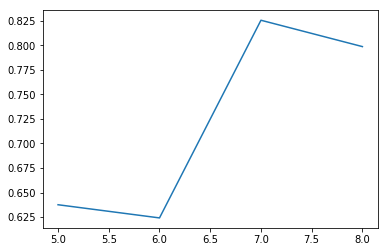

In [343]:
import matplotlib.pyplot
import pylab

a=[0.6375838926174496,0.6241610738255033,0.825503355704698,0.7986577181208053]
b=[5,6,7,8]

matplotlib.pyplot.plot(b,a)

matplotlib.pyplot.show()